<div align="center">
    <h1>Aprendizaje automático</h1>
    <h3>Fundamentos y aplicaciones en meteorología del espacio</h3>
    <h4>TP 2: Predicción</h4>
    <h5>Alumno: Federico Iza</h5>
</div>

# Predicción de series temporales

In [27]:
import pandas as pd
from tp2_settings import *
import matplotlib.pyplot as plt
from utils.plot import config_plots
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense
import matplotlib.dates as mdates
import datetime

In [28]:
%matplotlib inline
config_plots()

## Adquisición de datos

La celda siguiente lee los datos del archivo `sym_h_reduced.csv` usando la función `read_csv` de Pandas y considerando sólo las columnas `timestamp` y `SYM-H`. Luego las renombra por comodidad y ajusta el formato de la columna de fechas.

In [29]:
# Read data with selected columns.
df = pd.read_csv('../data/sym_h_reduced.csv',
                 usecols=['timestamp', 'SYM-H'])

# Rename columns.
df.rename(columns={'timestamp': 'Timestamp'}, inplace=True)

# Transform string to datetime format.
date_format = '%Y-%m-%d %H:%M:%S'
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=date_format)

In [30]:
df.head()

,Timestamp,SYM-H
0,2013-02-01 00:00:00,-10.0
1,2013-02-01 00:01:00,-10.0
2,2013-02-01 00:02:00,-10.0
3,2013-02-01 00:03:00,-10.0
4,2013-02-01 00:04:00,-10.0


La siguiente es una función auxiliar para darle el formato correcto a signo negativo.

In [31]:
def add_latex_minus(x: float) -> str:
    """
    Transforms a float into a latex-formated string in the case a minus
    is present.

    :param x: A float to transform into a string.
    :return: A string with the correct minus sign.
    """
    s = f'$-${np.abs(x)}' if x < 0 else f'{x}'
    return s

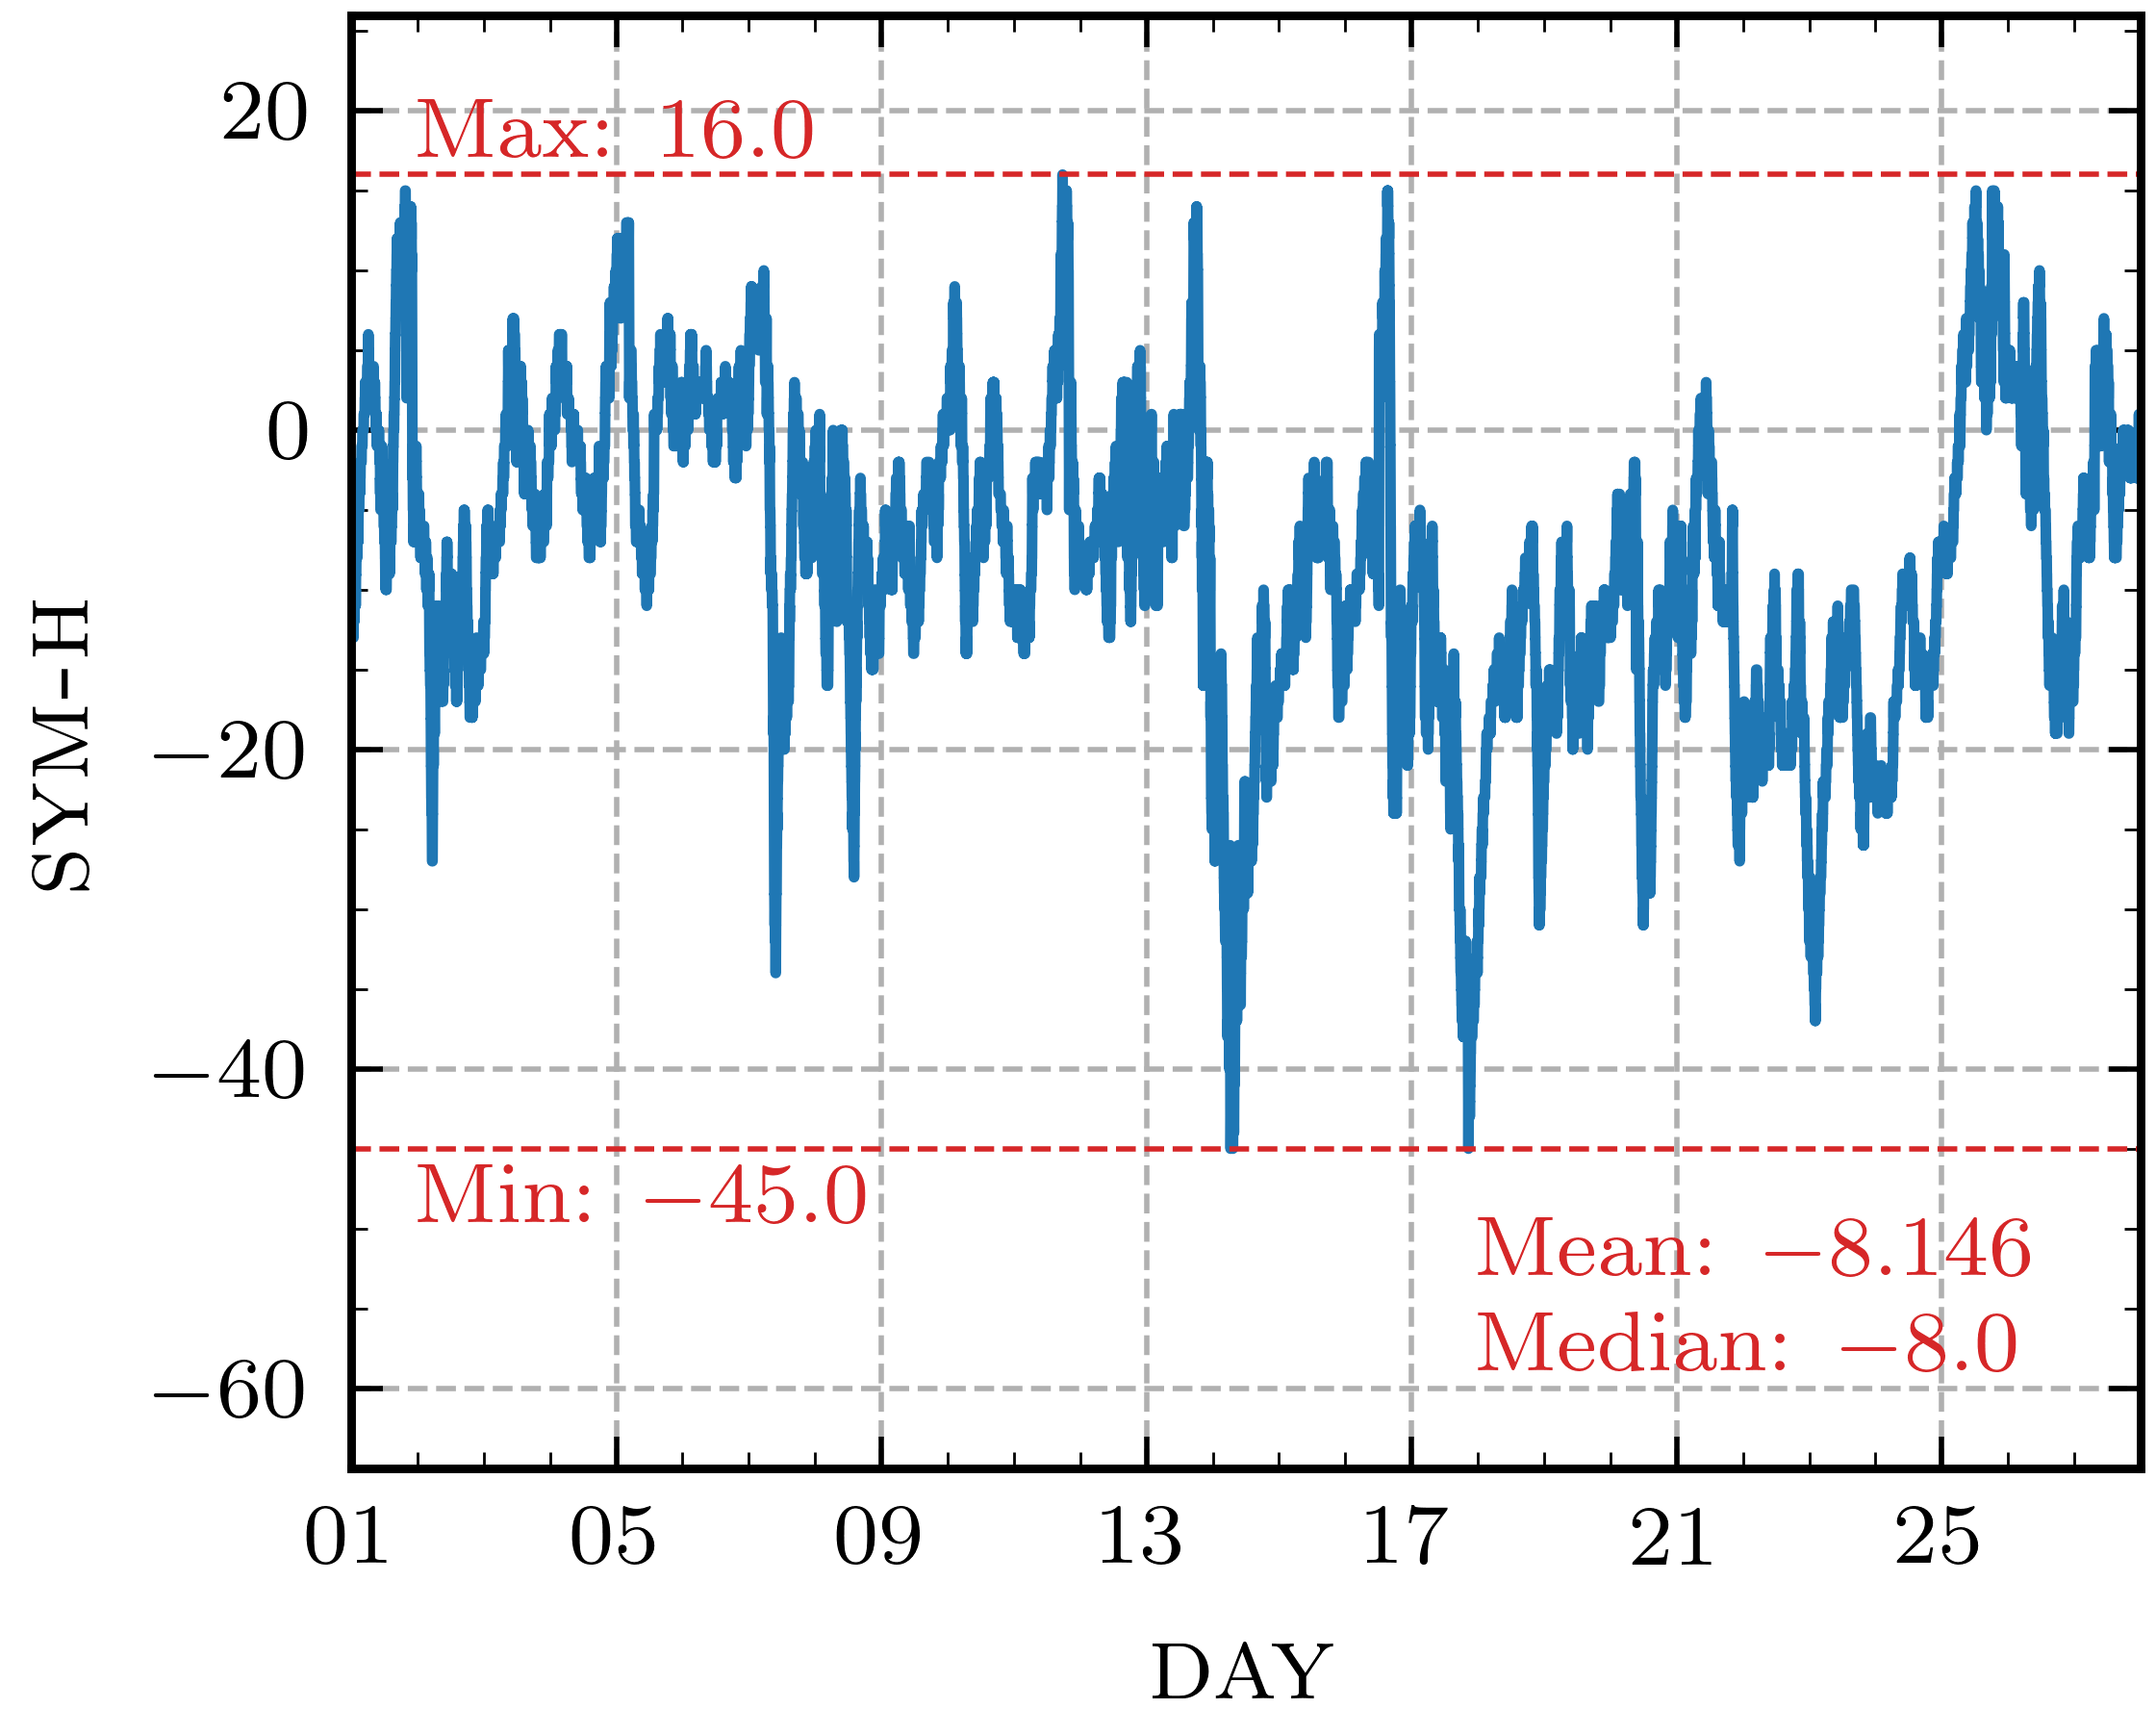

In [32]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel(r'\textsc{day}')
ax.set_ylabel(r'\textsc{sym-h}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlim(datetime.date(2013, 2, 1), datetime.date(2013, 2, 28))
ax.set_ylim(df['SYM-H'].min()-20, df['SYM-H'].max()+10)

# Plot data
ax.plot(df['Timestamp'], df['SYM-H'], color='tab:blue', ls='-', lw=1)

# Indicate statistics
ax.plot(ax.get_xlim(), [df['SYM-H'].max(), df['SYM-H'].max()],
        color='tab:red', ls='--', lw=0.5)
ax.text(x=datetime.date(2013, 2, 2), y=df['SYM-H'].max()+1,
        s=f'Max: {add_latex_minus(round(df["SYM-H"].max(), 3))}',
        color='tab:red')

ax.plot(ax.get_xlim(), [df['SYM-H'].min(), df['SYM-H'].min()],
        color='tab:red', ls='--', lw=0.5)
ax.text(x=datetime.date(2013, 2, 2), y=df['SYM-H'].min()-1,
        va='top', s=f'Min: {add_latex_minus(round(df["SYM-H"].min(), 3))}',
        color='tab:red')

ax.text(x=datetime.date(2013, 2, 18), y=df['SYM-H'].min()-8,
        s=f'Mean: {add_latex_minus(round(df["SYM-H"].mean(), 3))}',
        color='tab:red')
ax.text(x=datetime.date(2013, 2, 18), y=df['SYM-H'].min()-14,
        s=f'Median: {add_latex_minus(round(df["SYM-H"].median(), 3))}',
        color='tab:red')

fig.savefig('../images/tp2_fig1.pdf')
plt.show()
plt.close(fig)

El gráfico anterior muestra la evolución del índice SYM-H en función del día del mes. En rojo se indican las principales estadísticas de este dataset: la media, la mediana y los valores mínimo y máximo.

## Preparación de datos

La siguiente función toma como argumento un dataframe y selecciona la porción del mismo que se encuentra entre dos fechas dadas.

In [33]:
def select_interval(df: pd.DataFrame, init_date: str,
                    end_date: str) -> pd.DataFrame:
    """
    This function selects a specific time interval of the column 'Timestamp'
    of a given dataframe.

    :param df: Pandas dataframe that must contain the column 'Timestamp'.
    :param init_date: Initial date.
    :param end_date: End date.
    :return: A copy of the original dataframe with the data of the selected
             interval.
    """
    # Check if 'Timestamp' is in dataframe.
    if 'Timestamp' not in list(df.columns):
        raise Exception("'Timestamp' not found in dataframe columns.")

    df_reduced = df.loc[(df['Timestamp'] >= init_date)
                        & (df['Timestamp'] <= end_date)]
    return df_reduced

Creo un dataframe reduce con los valores de los primeros diez días del mes.

In [34]:
# Create a reduced data frame.
df_reduced = select_interval(df, '2013-02-01', '2013-02-10')

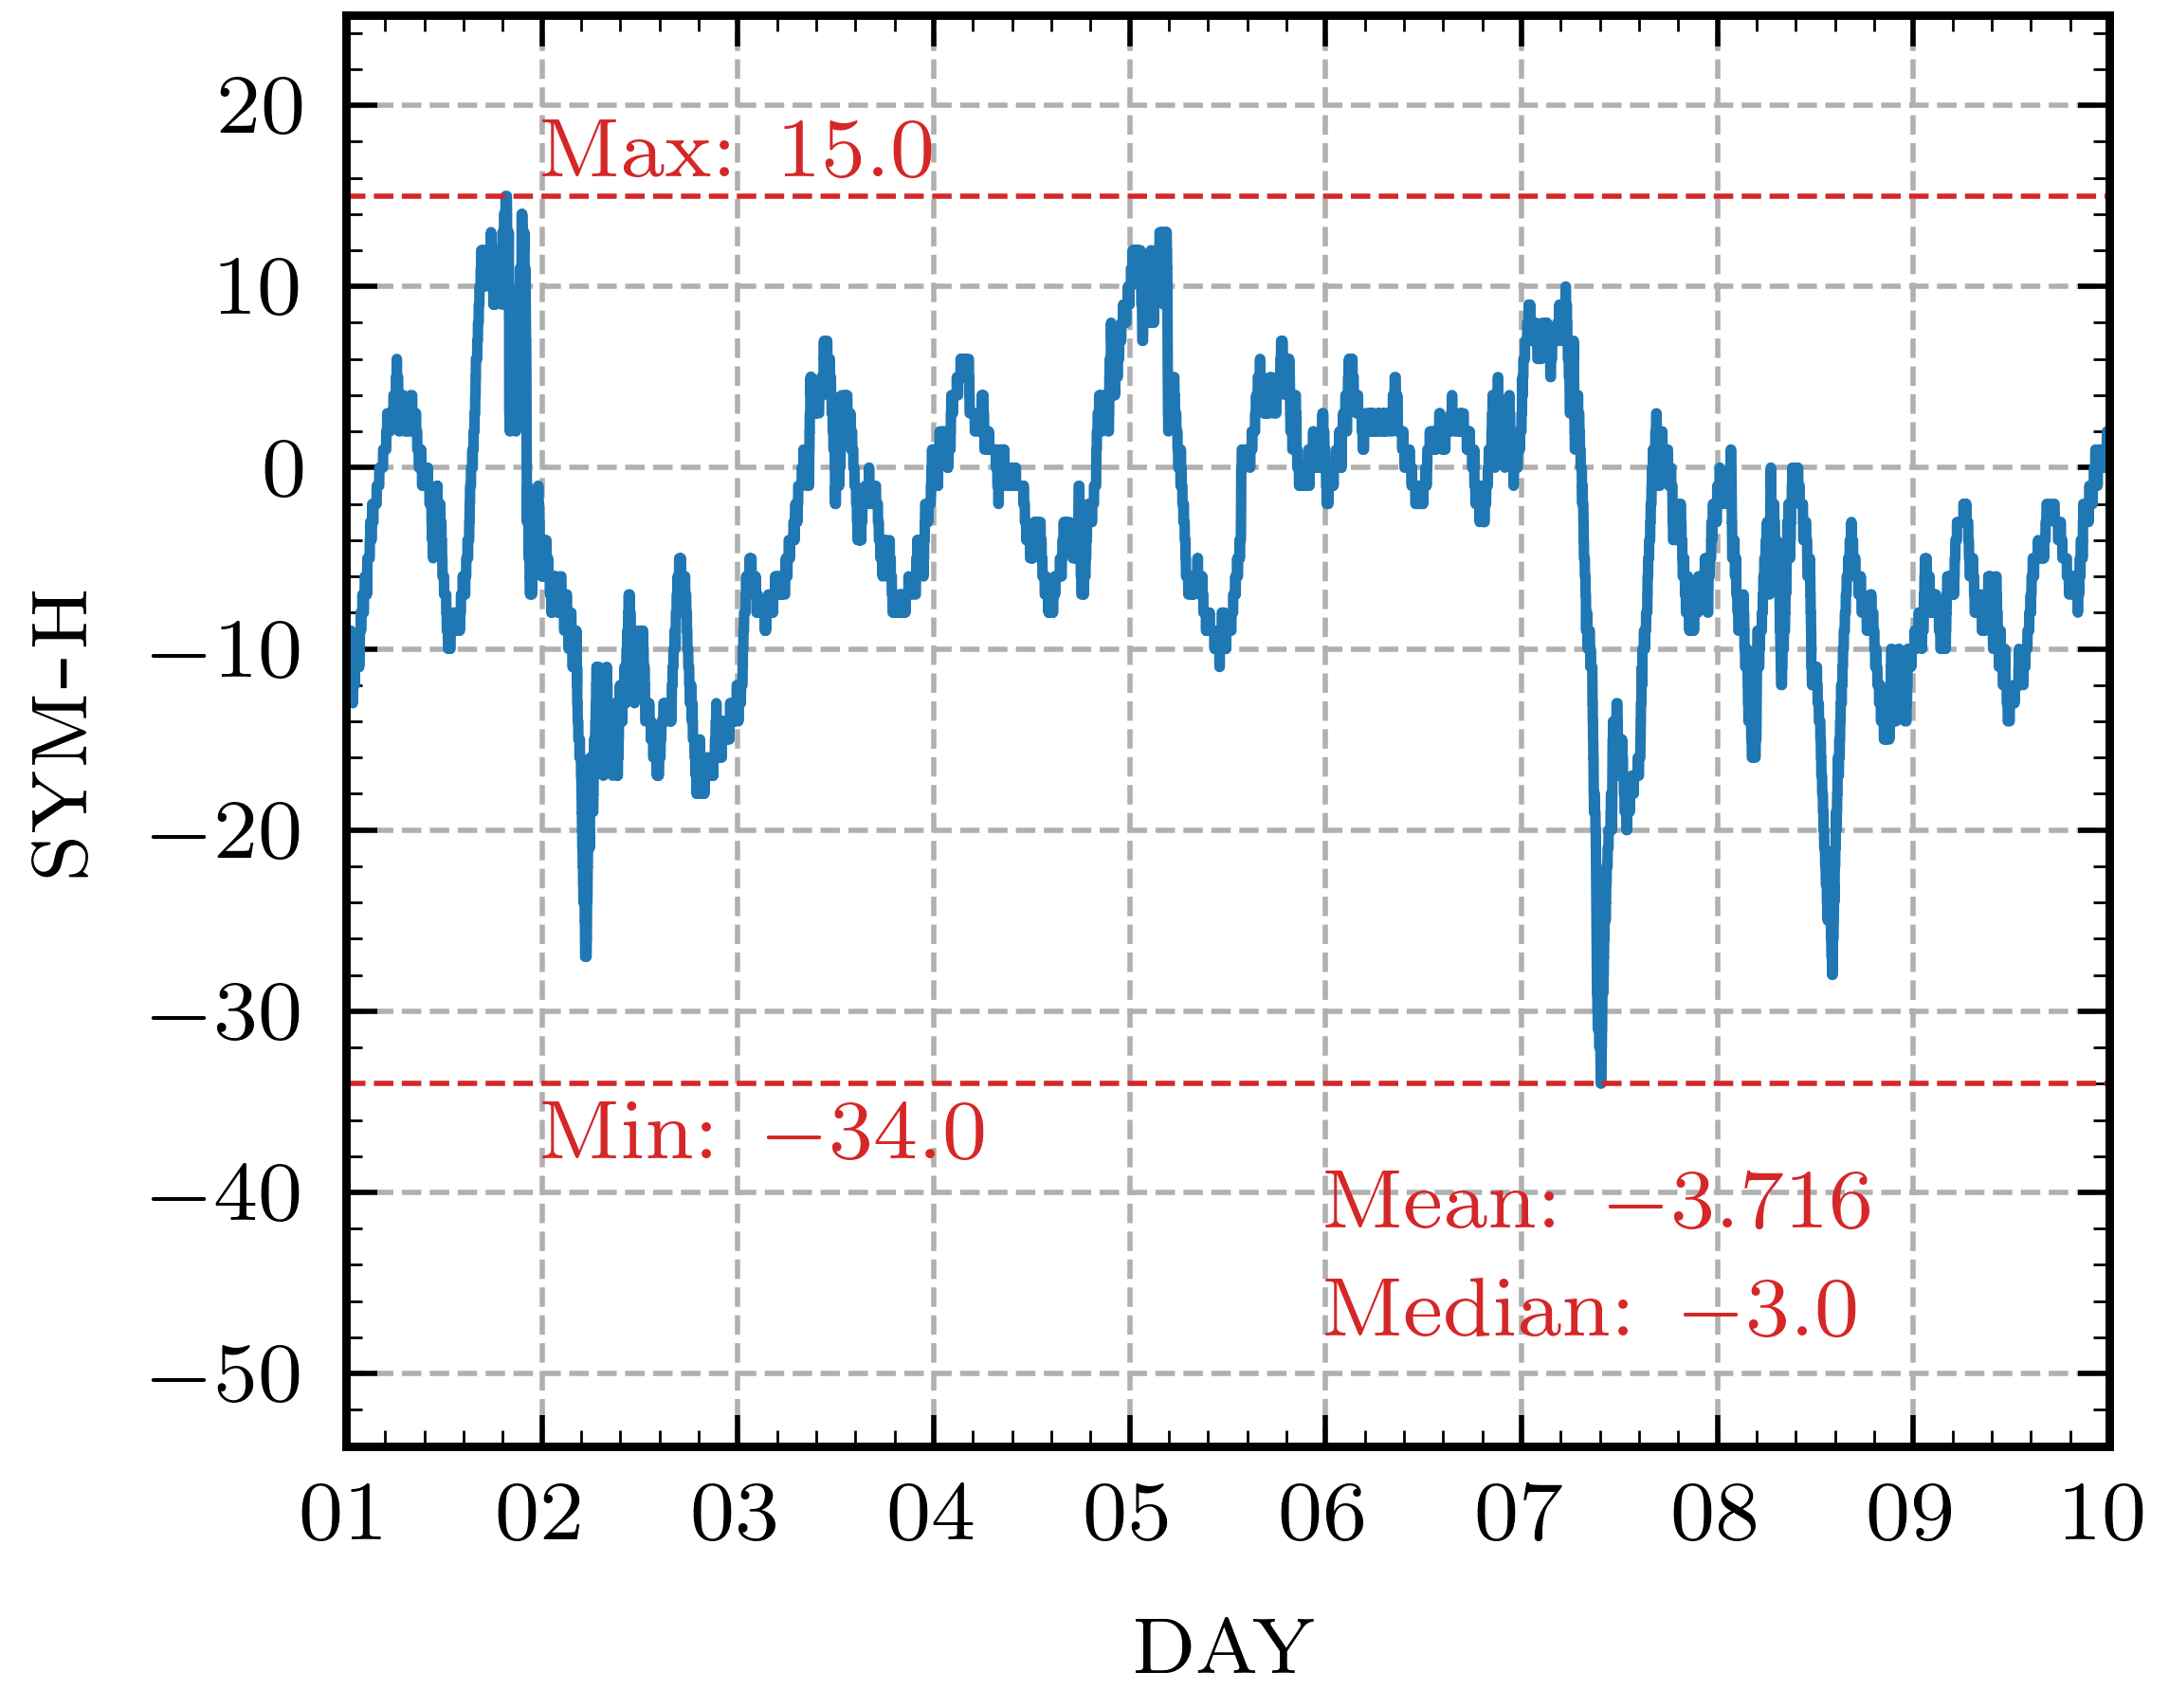

In [35]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel(r'\textsc{day}')
ax.set_ylabel(r'\textsc{sym-h}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlim(datetime.date(2013, 2, 1), datetime.date(2013, 2, 10))
ax.set_ylim(df_reduced['SYM-H'].min()-20, df_reduced['SYM-H'].max()+10)

# Plot data.
ax.plot(df_reduced['Timestamp'], df_reduced['SYM-H'],
        color='tab:blue', ls='-', lw=1)

# Indicate statistics.
ax.plot(ax.get_xlim(), [df_reduced['SYM-H'].max(), df_reduced['SYM-H'].max()],
        color='tab:red', ls='--', lw=0.5)
ax.text(x=datetime.date(2013, 2, 2),
        y=df_reduced['SYM-H'].max()+1,
        s=f'Max: {add_latex_minus(round(df_reduced["SYM-H"].max(), 3))}',
        color='tab:red')

ax.plot(ax.get_xlim(), [df_reduced['SYM-H'].min(), df_reduced['SYM-H'].min()],
        color='tab:red', ls='--', lw=0.5)
ax.text(x=datetime.date(2013, 2, 2),
        y=df_reduced['SYM-H'].min()-1, va='top',
        s=f'Min: {add_latex_minus(round(df_reduced["SYM-H"].min(), 3))}',
        color='tab:red')

ax.text(x=datetime.date(2013, 2, 6),
        y=df_reduced['SYM-H'].min()-8,
        s=f'Mean: {add_latex_minus(round(df_reduced["SYM-H"].mean(), 3))}',
        color='tab:red')
ax.text(x=datetime.date(2013, 2, 6),
        y=df_reduced['SYM-H'].min()-14,
        s=f'Median: {add_latex_minus(round(df_reduced["SYM-H"].median(), 3))}',
        color='tab:red')

fig.savefig('../images/tp2_fig2.pdf')
plt.show()
plt.close(fig)

El gráfico anterior es análogo al ya mostrado pero incluyendo sólo los primeros diez días del mes.

## Ingeniería de datos

### ¿Hay datos inválidos?

In [36]:
np.sum(df == np.nan)

Timestamp    0
SYM-H        0
dtype: int64

La celda anterior muestra que no hay datos inválidos en el dataset.

## Preprocesamiento de datos

No hay necesidad de escribir una nueva función para separar los datos ya que se puede usar la incluida de ```scikit-learn``` para esto.

In [37]:
data_train, data_test = train_test_split(df_reduced['SYM-H'],
                                         test_size=TEST_SIZE,
                                         shuffle=False)

A continuación inicio el escalador y lo entreno usando los datos de entrenamiento.

In [38]:
scaler = MinMaxScaler()
data_train = data_train.to_numpy().reshape(-1, 1)
data_train_scaled = scaler.fit_transform(data_train)

El mismo escalador entrenado con los datos de entrenamiento debe usarse para transformar los datos de prueba.

In [39]:
data_test = data_test.to_numpy().reshape(-1, 1)

# Use the scaler trained with the train data.
data_test_scaled = scaler.transform(data_test)

La siguiente función calcula una ventana para una secuencia dada.

In [40]:
def split_sequence(sequence: np.ndarray, n_steps_in: int,
                   n_steps_out: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the sliding windows for a given sequence.

    :param sequence: A sequence of data in which the sliding window will be
                     computed.
    :param n_steps_in: The number of input steps for training.
    :param n_steps_out: The number of output steps for testing.
    :return: Returns a tuple of np.ndarray with the stored subsequences.
    """
    x, y = [], []
    for i in range(len(sequence)):
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out
        if out_end_idx > len(sequence):
            break
        seq_x = sequence[i:end_idx]
        seq_y = sequence[end_idx:out_end_idx]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

Aplico la función `split_sequence` a los datos de entrenamiento escalados, usando los valores de `n_steps_in` y `n_steps_out` definidos en `code/tp2_settings.py`.

In [41]:
# Define sliding window
x, y = split_sequence(data_train_scaled,
                      n_steps_in=N_STEPS_IN,
                      n_steps_out=N_STEPS_OUT)

## Modelado

Creo un modelo con dos capas, lo compilo y lo ajusto a los datos que obtuve luego de aplicar la función `split_sequence`.

In [42]:
model = Sequential()

model.add(Dense(units=N_NEURONS,
                activation=ACTIVATION_FUNCTION,
                input_dim=N_STEPS_IN))

model.add(Dense(units=N_STEPS_OUT))

model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION)

history = model.fit(x, y, epochs=N_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=VERBOSE_TYPE)

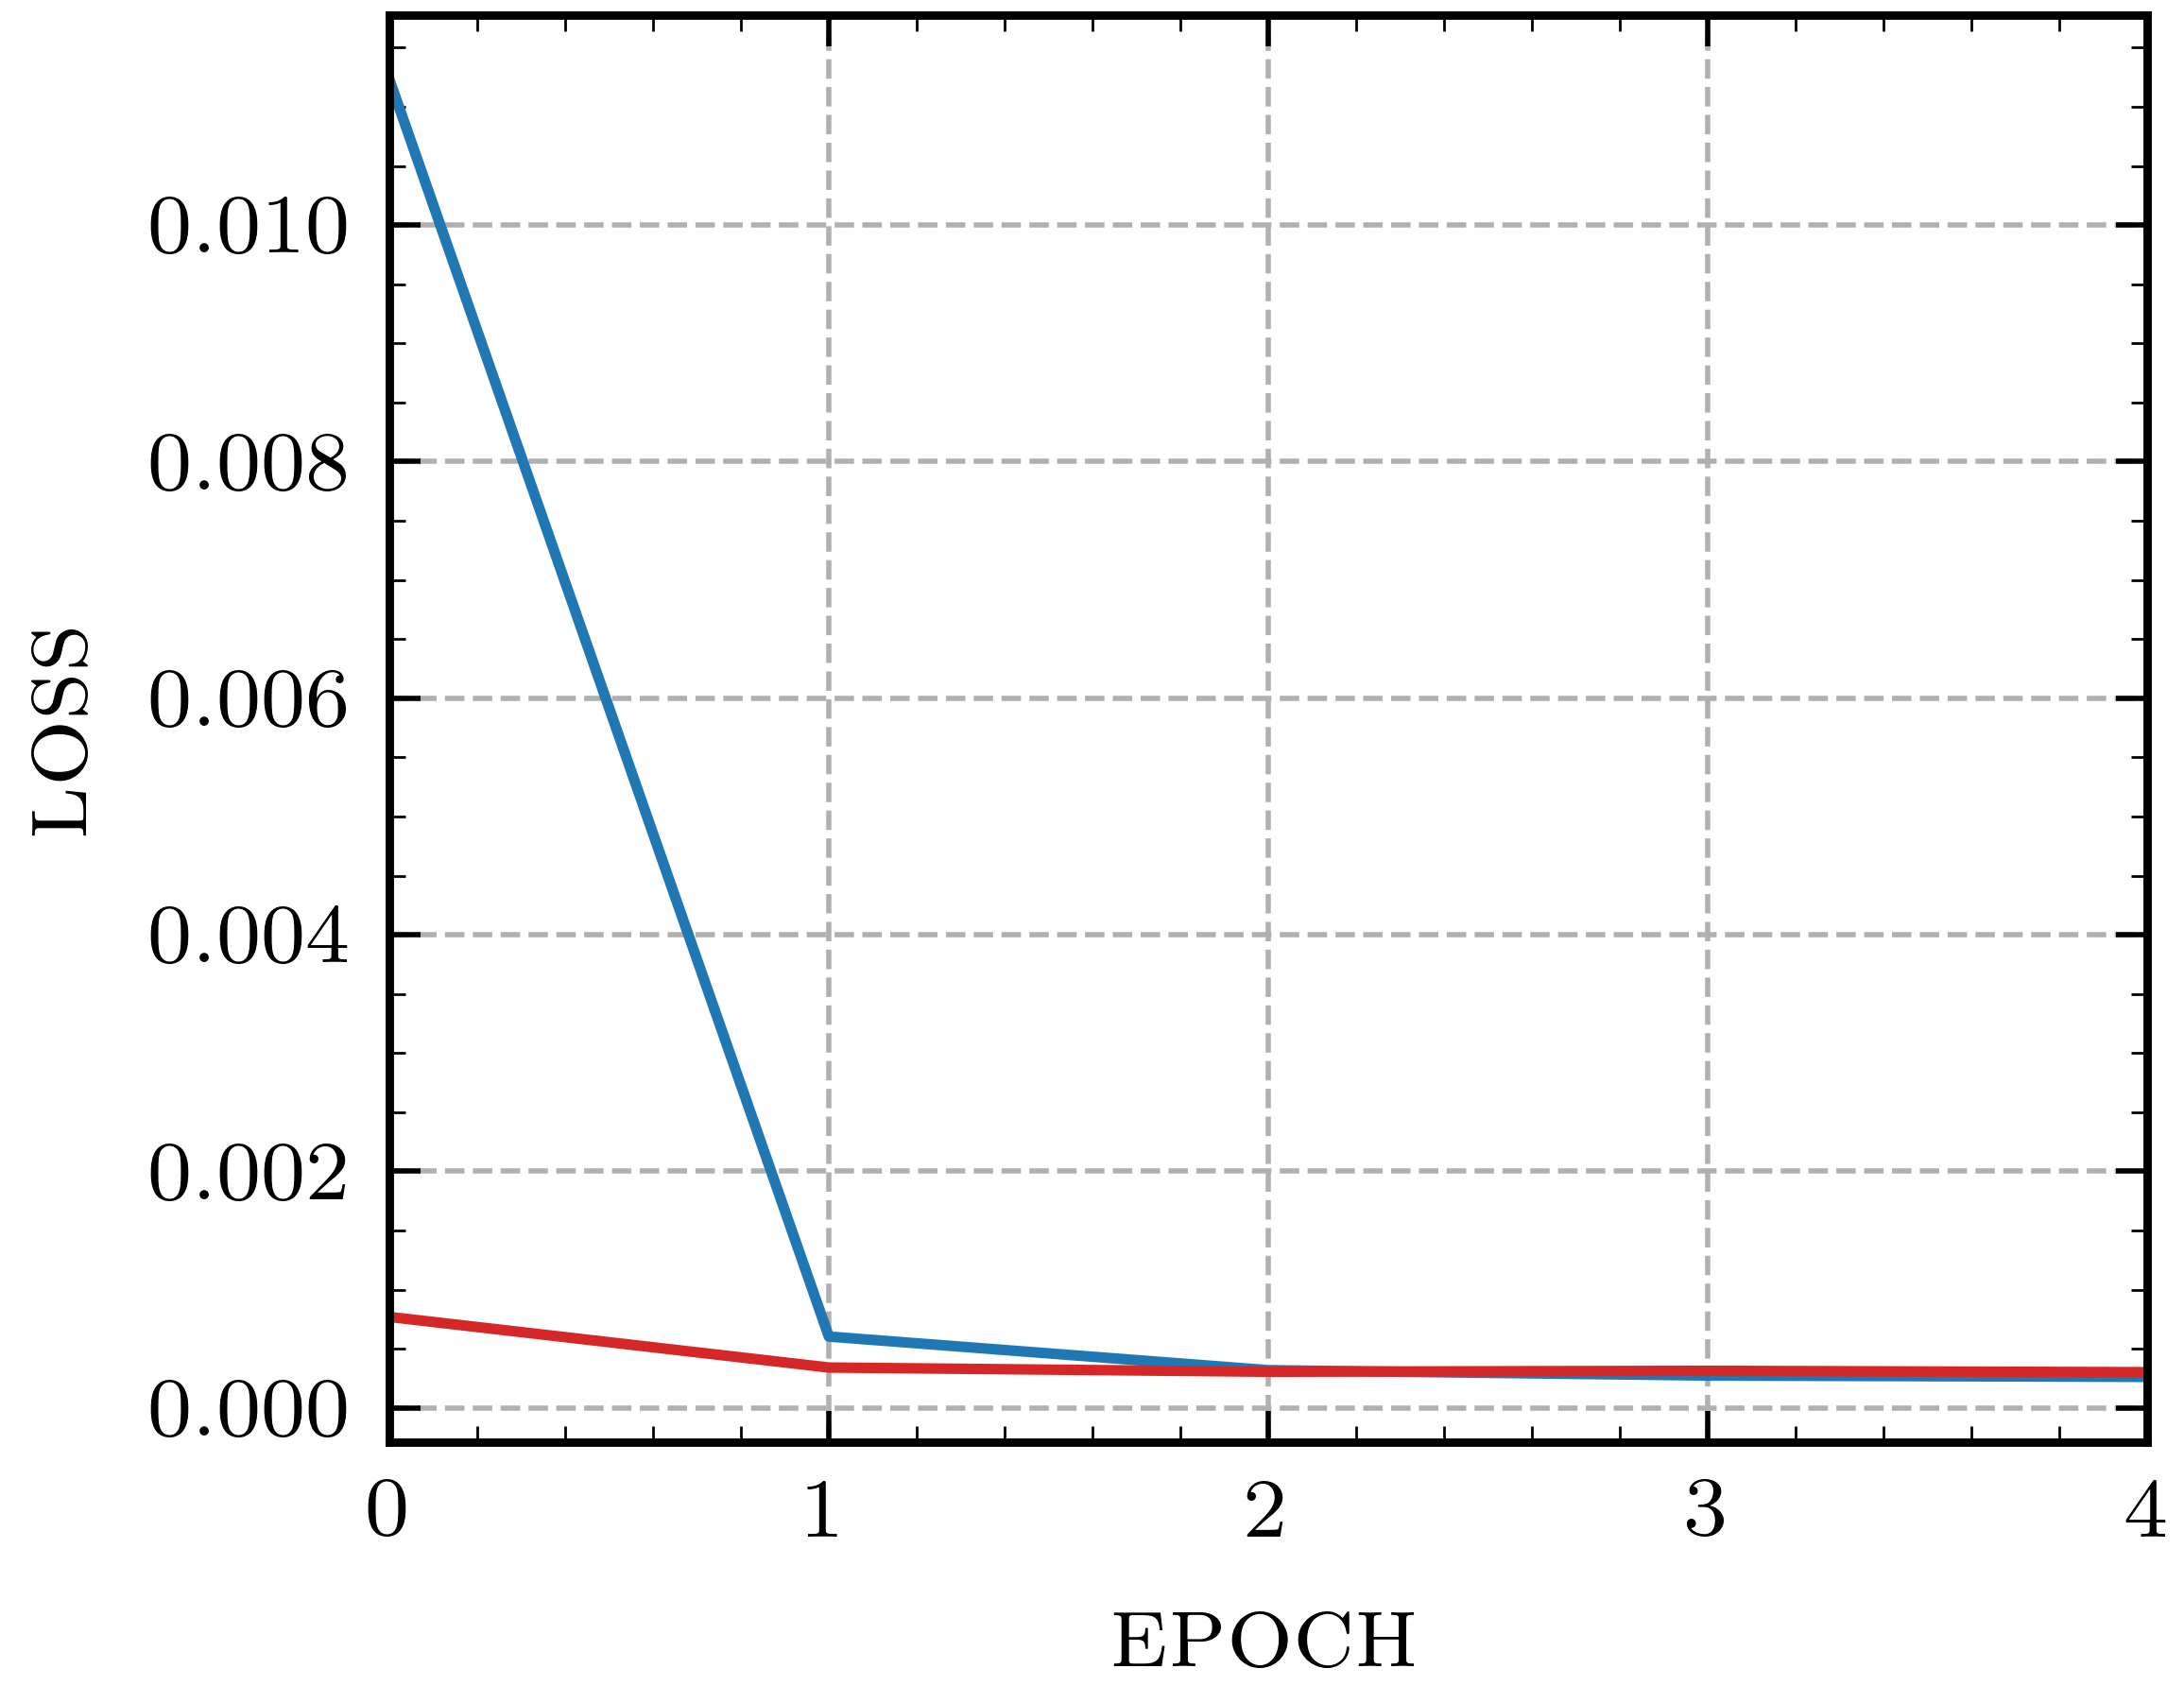

In [43]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel(r'\textsc{epoch}')
ax.set_xlim(0, N_EPOCHS-1)
# ax.set_ylim(0, ax.get_ylim()[1])

ax.set_ylabel(r'\textsc{loss}')
ax.plot(history.history['loss'],
        color='tab:blue', ls='-', lw=1)
ax.plot(history.history['val_loss'],
        color='tab:red', ls='-',  lw=1, label='Validation')

fig.savefig('../images/tp2_fig3.pdf')
plt.show()
plt.close(fig)

El gráfico anterior muestra una rápida convergencia, por lo que no sería necesario agregar más épocas de entrenamiento.

## Predicción y validación

Predicción de los primeros tres datos del set de prueba:

In [44]:
print('Últimos cinco (N_STEPS_IN) valores escalados de'
      + 'los datos de entrenamiento: ', end='')
for val in data_train_scaled[-N_STEPS_IN:].flatten():
    print(f'{val} ', end='')

y_hat1 = model.predict(data_train_scaled[-N_STEPS_IN:].reshape(1, -1),
                       verbose=0)
print('\n\nPredicción de los primeros tres (N_STEPS_OUT) '
      + 'valores de los datos de prueba: ', end='')
for val in y_hat1.flatten():
    print(f'{val} ', end='')

mse = mean_squared_error(
    y_hat1, data_test_scaled[0:N_STEPS_OUT].reshape(1, -1))
print(f'\n\nEl error cuadrático medio de esta predicción es: {mse}')

Últimos cinco (N_STEPS_IN) valores escalados delos datos de entrenamiento: 0.38775510204081637 0.38775510204081637 0.38775510204081637 0.38775510204081637 0.40816326530612246 

Predicción de los primeros tres (N_STEPS_OUT) valores de los datos de prueba: 0.39399123191833496 0.3923483192920685 0.38830646872520447 

El error cuadrático medio de esta predicción es: 0.003659022010372482


La función siguiente produce el avance sobre el dataset de prueba y genera predicciones a medida que avanza. Para ello, toma como parámetros el dataset completo (sin escalar), el tamaño del dataset de prueba y el parámetro `n_steps_in`.

In [45]:
def walk_forward(data: np.ndarray, n_test: int,
                 n_steps_in: int) -> np.ndarray:
    """
    This method walks on the test dataset and generates the predictions.

    :param data: The original (complete) dataset without scaling.
    :param n_test: The size of the test dataset.
    :param n_steps_in: The value of the input parameter of the sliding window.
    :return: Returns an array with the predictions for the test dataset.
    """
    y_hat = []
    n_train = len(data) - n_test
    data_scaled = scaler.transform(data.reshape(-1, 1))
    for i in range(n_test):
        y_hat.append(model.predict(
            data_scaled[n_train-n_steps_in+i:n_train+i].reshape(1, -1),
            verbose=VERBOSE_TYPE)[0, 0])
    y_hat = np.array(y_hat)
    y_pred = scaler.inverse_transform(y_hat.reshape(1, -1))
    return y_pred

Genero las predicciones del dataset de testeo.

In [46]:
y_pred = walk_forward(df_reduced['SYM-H'].to_numpy(),
                     len(data_test_scaled), N_STEPS_IN)

In [47]:
mse = mean_squared_error(
    y_pred, data_test.reshape(1, -1))
print(f'El error cuadrático medio de esta predicción es {mse}.')

El error cuadrático medio de esta predicción es 0.3513158977287234.


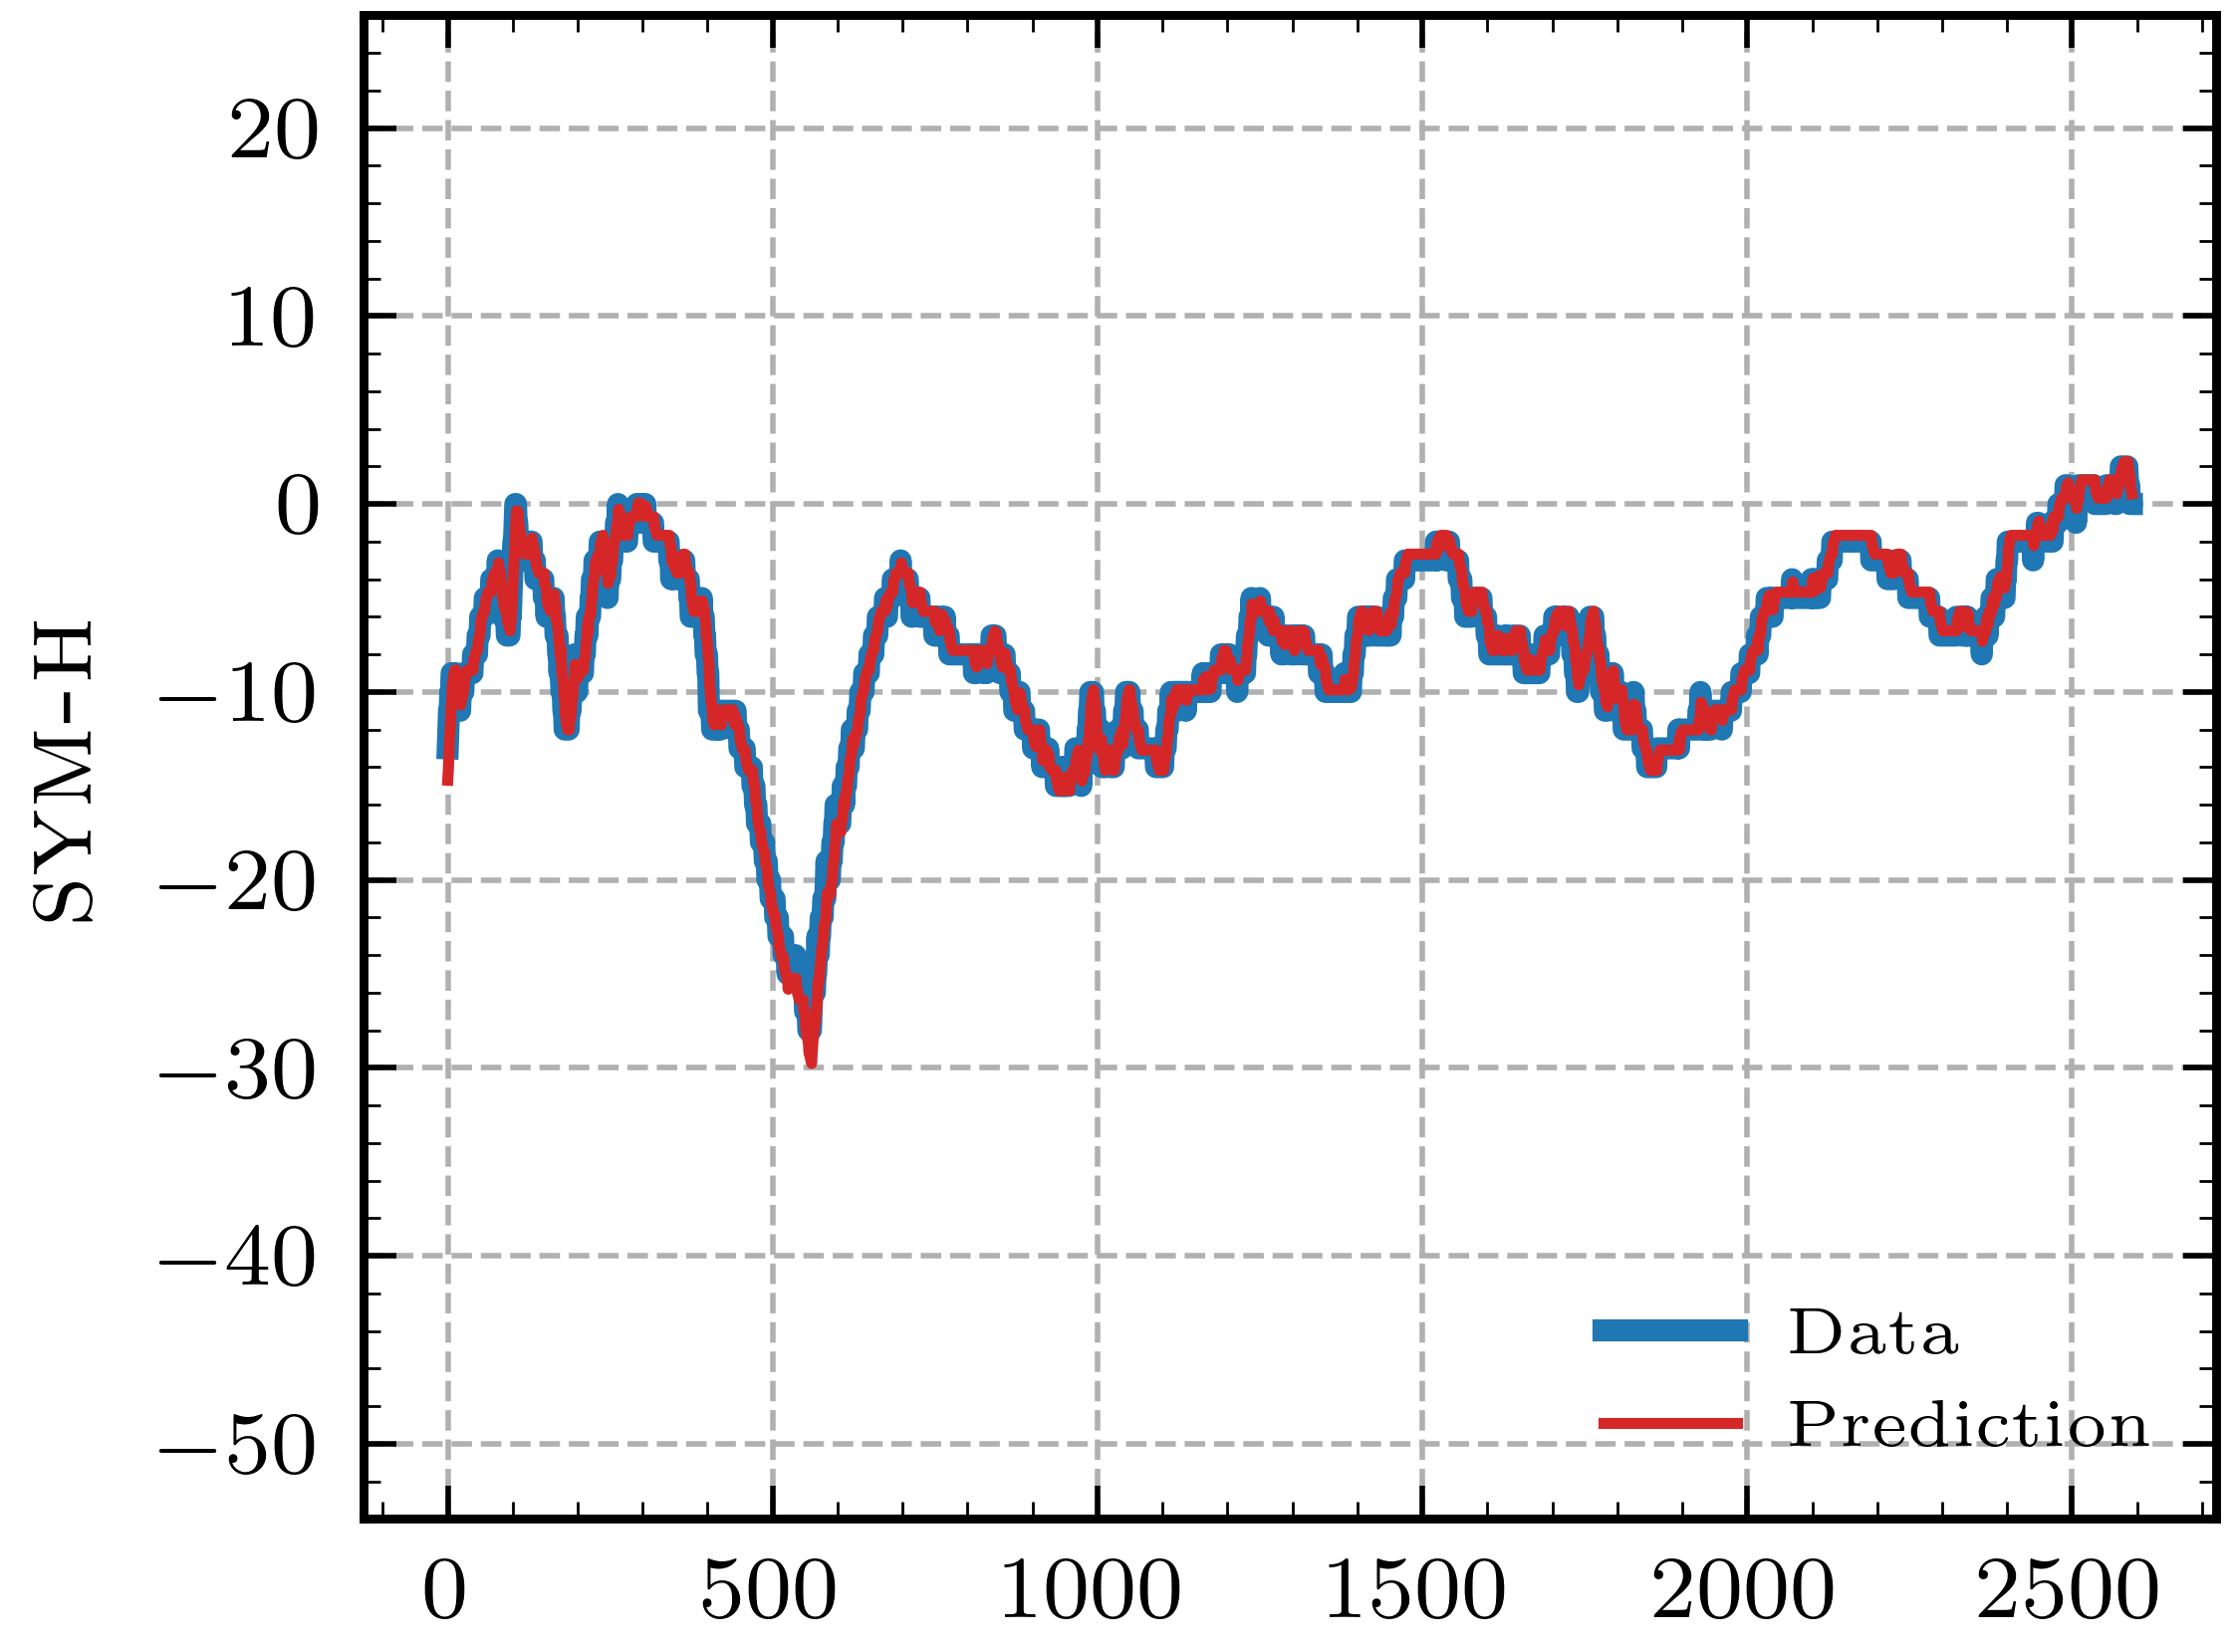

In [48]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_ylabel(r'\textsc{sym-h}')
ax.set_ylim(df_reduced['SYM-H'].min()-20, df['SYM-H'].max()+10)

# Plot data
ax.plot(np.array(df_reduced['SYM-H'])[-len(data_test):],
        color='tab:blue', ls='-', lw=2, label='Data')
ax.plot(y_pred.flatten(),
        color='tab:red', ls='-', lw=1, label='Prediction')

ax.legend(loc='lower right', framealpha=0)
fig.savefig('../images/tp2_fig4.pdf')
plt.show()
plt.close(fig)

## Función `grid_search`

La función siguiente hace un búsqueda por una grilla en el espacio de fases compuesto por el número de neuronas en la primera capa de la ren y la cantidad de épocas consideradas para realizar el entrenamiento. Por cada modelo generado, imprime la configuración y el MSE. Éste último se calcula (por cuestiones de velocidad) sólo con la predicción de los primeros tres datos del set de prueba.

In [49]:
def grid_search(n_neurons_lst: list[int], n_epochs_lst: list[int]) -> None:
    """
    This method uses a grid search for two hyperparameters (number of
    neurons in the only layer of the model and number of epochs for
    iteration) in the neural network defined and returns the best model.

    :param n_neurons_lst: List with integers that indicate the number of neurons
                          to consider in each model.
    :param n_epochs_lst: List with integers that indicate the number of
                         epochs to use in the training of each model.
    """
    print('N_NEURONS\t\tN_EPOCHS\t\tMSE')

    for n_neurons in n_neurons_lst:
        for n_epochs in n_epochs_lst:
            # Initialize the model.
            model = Sequential()

            # Define the architecture of the ANN.
            model.add(Dense(units=n_neurons,
                            activation=ACTIVATION_FUNCTION,
                            input_dim=N_STEPS_IN))
            model.add(Dense(units=N_STEPS_OUT))

            # Compile the model.
            model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION)

            # Fit the model.
            _ = model.fit(x, y, epochs=n_epochs,
                          validation_split=VALIDATION_SPLIT,
                          verbose=VERBOSE_TYPE)

            # Make a prediction and calculate the MSE.
            y_hat1 = model.predict(
                data_train_scaled[-N_STEPS_IN:].reshape(1, -1),
                verbose=0)
            new_mse = mean_squared_error(
                y_hat1, data_test_scaled[0:N_STEPS_OUT].reshape(1, -1))

            print(f'{n_neurons}\t\t\t\t{n_epochs}\t\t\t\t{new_mse}')

In [50]:
grid_search(n_neurons_lst=[20, 30, 40, 50], n_epochs_lst=[5, 10, 15, 20])

N_NEURONS		N_EPOCHS		MSE
20				5				0.0021908053457265516
20				10				0.0038797757374138702
20				15				0.004688399208767432
20				20				0.0031804172326779685
30				5				0.0035776372712670312
30				10				0.004549130820560532
30				15				0.003394668741630927
30				20				0.00403163819250753
40				5				0.0031886154986387337
40				10				0.003941151740177973
40				15				0.0038936630592365743
40				20				0.0032301301842709365
50				5				0.003581040454139307
50				10				0.0035549799808851207
50				15				0.003917398893163704
50				20				0.0036499722499086676


Observando la impresión de la celda anterior es posible concluir que el mejor modelo (el que tiene menor MSE) es el que consta de 20 neuronas y 5 épocas de entrenamiento.